In [105]:
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

from PIL import Image
from tools import analytics
from neuralvision.tops.config.instantiate import instantiate
import torchvision
import torch
import numpy as np

In [106]:
URL = "datasets/tdt4265/images/train/trip007_glos_Video00000_9.png"
img = Image.open(URL).convert("RGB")

In [107]:
CFG_PATH = "neuralvision/configs/retina_P4.py"
SET_TYPE = "train"
BATCH_SIZE = 1 

cfg_file = analytics.get_config(CFG_PATH)
cfg, dataset, gpu_tfms = analytics.prepare_dataset(cfg_file, dataset_type=SET_TYPE, batch_size=BATCH_SIZE)
img_mean, img_std = analytics.calculate_mean_std(cfg)

print(f"Using transforms: ")
[print(f["_target_"]) for f in cfg.data_train.dataset.transform.transforms]

Saving SSD outputs to: outputs/
Using transforms: 
<class 'neuralvision.transforms.transform.RandomSampleCrop'>
<class 'neuralvision.transforms.transform.ToTensor'>
<class 'neuralvision.transforms.transform.Resize'>
<class 'neuralvision.transforms.transform.RandomHorizontalFlip'>


[None, None, None, None]

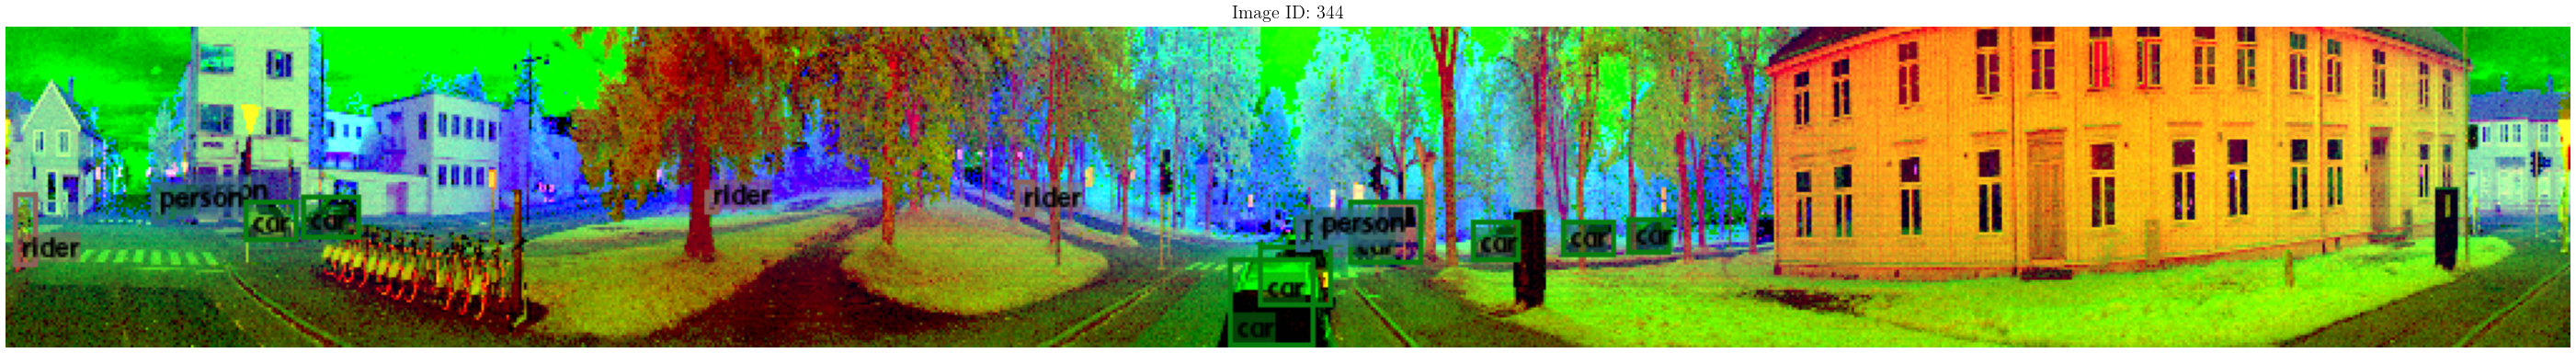

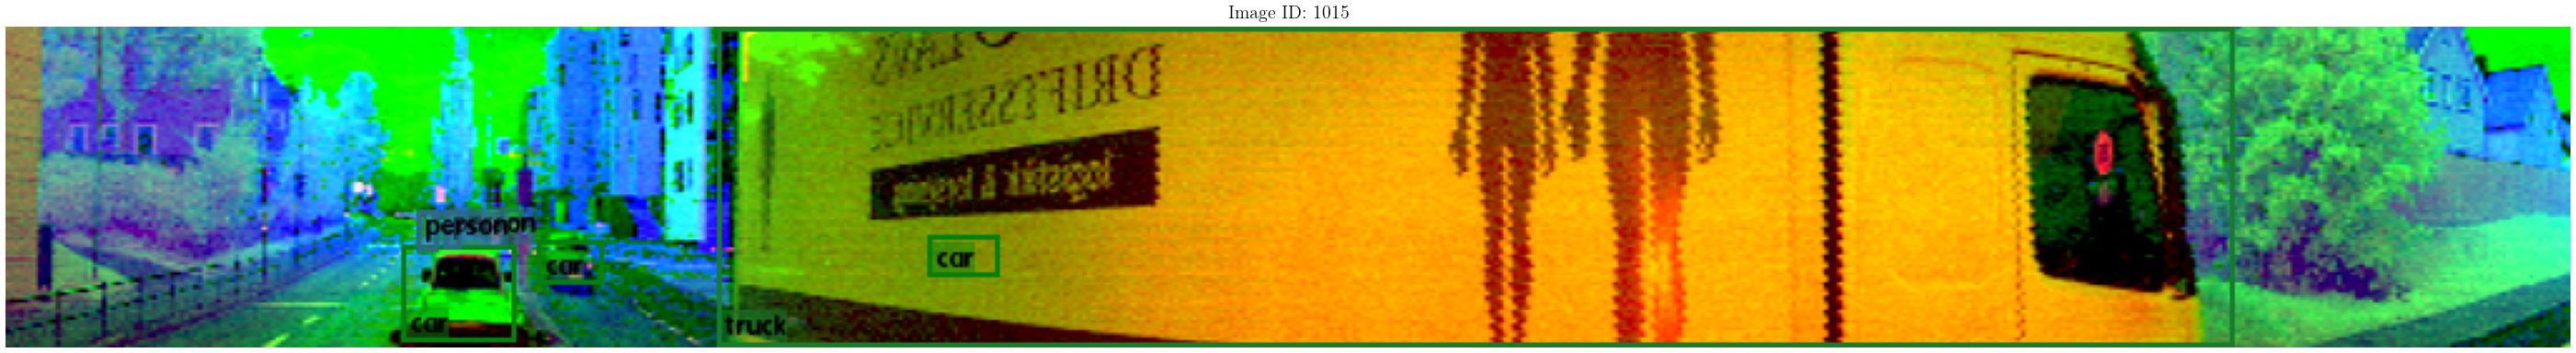

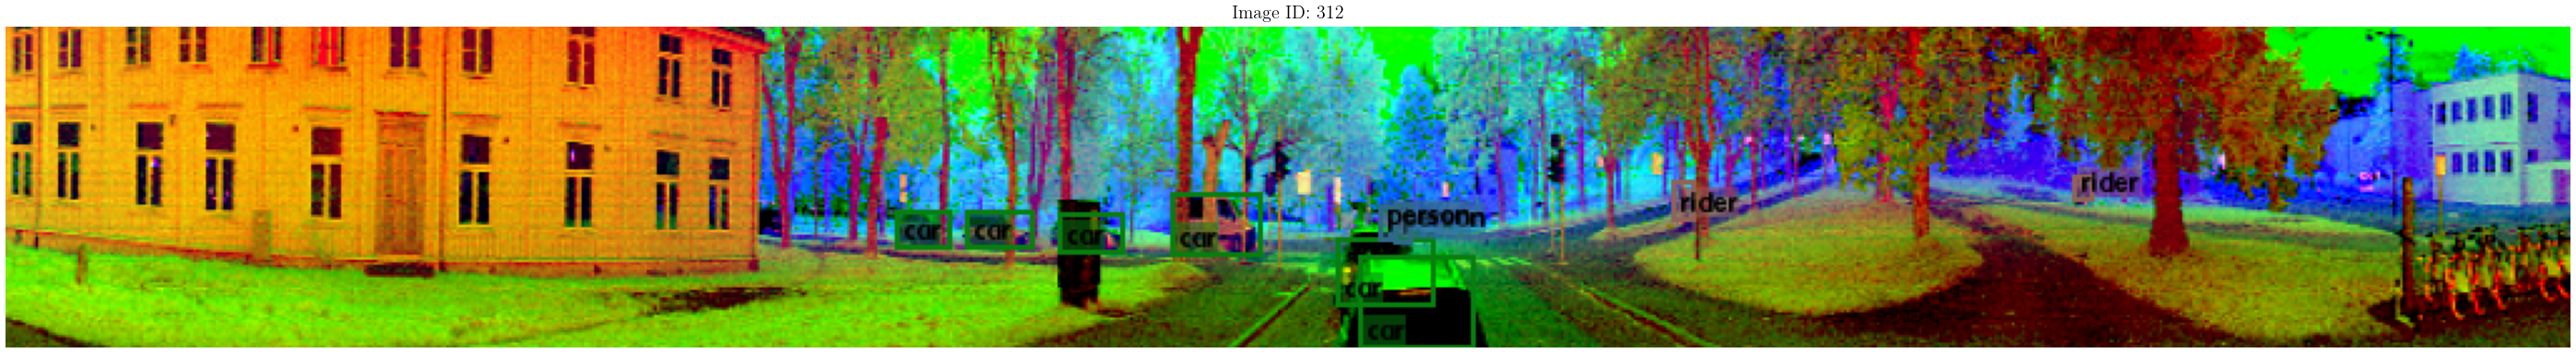

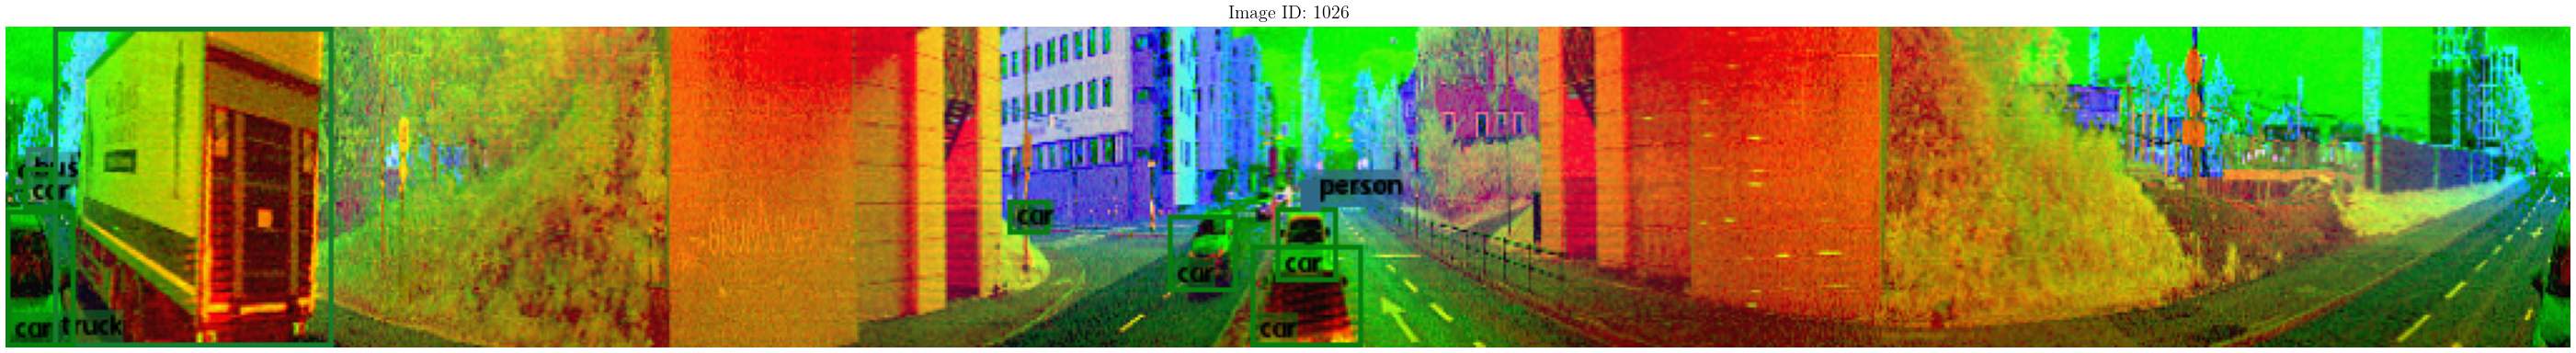

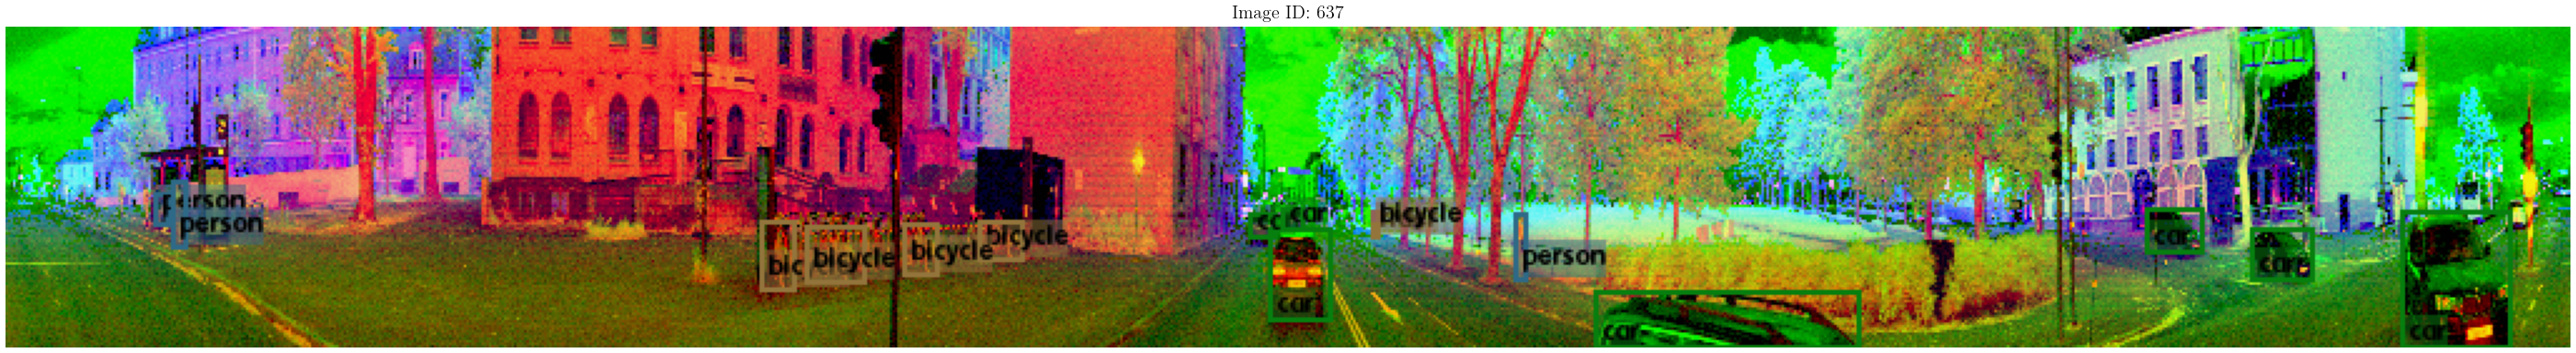

In [108]:
MAX_SAMPLES = 5

for idx, sample in enumerate(iter(dataset)):
    image, boxes = analytics.preprocess_sample(
        sample,
        gpu_tfms,
        img_std,
        img_mean
    )
    analytics.visualize_sample(
        img_id = sample["image_id"][0],
        image = image,
        boxes = boxes,
        labels = sample["labels"][0].cpu().numpy().tolist(),
        lblmap = cfg.label_map
    )  

    if (idx+1) >= MAX_SAMPLES:
        break

In [109]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = instantiate(cfg.model)
model.eval()
model.eval().to(device)


RetinaNet(
  (feature_extractor): ResnetFPN(
    (backbone): ResNet(
      (tail): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [110]:
model

RetinaNet(
  (feature_extractor): ResnetFPN(
    (backbone): ResNet(
      (tail): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [111]:
rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [112]:
maps = rcnn.backbone(torch.randn(1, 3, 224, 224))

maps.keys()

odict_keys(['0', '1', '2', '3', 'pool'])

In [113]:
maps["pool"].shape

torch.Size([1, 256, 4, 4])

In [114]:
maps["pool"].shape[-2:]

torch.Size([4, 4])

In [115]:
ina = model.feature_extractor

In [116]:
test_img = torch.randn(1, 3, 128, 1024).to(device)
maps = ina(test_img)

for ma in maps:
    print(ma.shape)

torch.Size([1, 256, 32, 256])
torch.Size([1, 256, 16, 128])
torch.Size([1, 256, 8, 64])
torch.Size([1, 256, 4, 32])
torch.Size([1, 256, 2, 16])
torch.Size([1, 256, 1, 8])


In [117]:
def fasterrcnn_reshape_transform(features):
    target_size = features[-1].size()[-2:]
    activations = []
    for feat in features:
        activations.append(torch.nn.functional.interpolate(torch.abs(feat), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

In [118]:
class FasterRCNNBoxScoreTarget:
    """ For every original detected bounding box specified in "bounding boxes",
        assign a score on how the current bounding boxes match it,
            1. In IOU
            2. In the classification score.
        If there is not a large enough overlap, or the category changed,
        assign a score of 0.

        The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        if len(model_outputs["boxes"]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs["boxes"])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs["labels"][index] == label:
                score = ious[0, index] + model_outputs["scores"][index]
                output = output + score
        return output

In [119]:
labels = None
boxes = None

In [120]:
URL = "datasets/tdt4265/images/train/trip007_glos_Video00000_9.png"
img = Image.open(URL).convert("RGB")
input_tensor = np.array(img)
image_float_np = np.float32(image) / 255
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)


In [121]:
ds = iter(dataset)
sample = next(ds)
from vizer.draw import draw_boxes

image, boxes = analytics.preprocess_sample(
    sample,
    gpu_tfms,
    img_std,
    img_mean
)

In [122]:
image = transform(image)
image = image.unsqueeze(0)

In [123]:
target_layers = [model.feature_extractor]
targets = [FasterRCNNBoxScoreTarget(labels=sample["labels"], bounding_boxes=boxes)]
cam = EigenCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(),
               reshape_transform=fasterrcnn_reshape_transform)

grayscale_cam = cam(image.to(device), targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# Add boxes
im = draw_boxes(
    image=cam_image,
    boxes=boxes,
    labels=labels,
    class_name_map=cfg.label_map,
    width=2,
)
Image.fromarray(im)

x: torch.Size([1, 256, 32, 256])
x: torch.Size([1, 256, 16, 128])
x: torch.Size([1, 256, 8, 64])
x: torch.Size([1, 256, 4, 32])
x: torch.Size([1, 256, 2, 16])
x: torch.Size([1, 256, 1, 8])


/home/andy/dev/neuralvision/venv/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


TypeError: tuple indices must be integers or slices, not str